In [6]:
%matplotlib ipympl
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import pathlib

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import constants
import datasetloader
import model

In [7]:
tf.random.set_seed(constants.RANDOM_SEED)
DATASET_SAVED_PATH:pathlib.Path = pathlib.Path('./', 'ModelNet10')
""" Load the pointcloud dataset """
train_points, test_points, train_labels, test_labels, class_map = datasetloader.processDataset(DATASET_SAVED_PATH, constants.UNIFORM_SAMPLE_COUNT)
# test_labels.shape = (test_labels.shape[0], 1)
print('TEST SHAPES ::: ', test_points.shape, test_labels.shape)

print('LOAD WEIGHTS FROM A CHECKPOINT')
checkpoint_path = pathlib.Path('./trained_model/checkpoints')

""" Create the tensor slices of the loaded dataset (for both training and testing) """
print('CREATEING THE TENSOR SLICES FOR THE TRAINING AND TESTING DATASET')
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

print('TEST DATASET SHAPES :::: ', test_dataset)
""" Apply shuffling and agumentation to the training dataset """
print('APPLYING THE AUGMENTATION FOR THE TRAINING AND TESTING DATASETS')
train_dataset = train_dataset.shuffle(len(train_points)).map(datasetloader.augmentation).batch(constants.BATCH_SIZE)
""" Apply shuffling only for the testing dataset """
test_dataset = test_dataset.shuffle(len(test_points)).batch(constants.BATCH_SIZE)

TEST SHAPES :::  (908, 2048, 3) (908,)
LOAD WEIGHTS FROM A CHECKPOINT
CREATEING THE TENSOR SLICES FOR THE TRAINING AND TESTING DATASET
TEST DATASET SHAPES ::::  <TensorSliceDataset element_spec=(TensorSpec(shape=(2048, 3), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
APPLYING THE AUGMENTATION FOR THE TRAINING AND TESTING DATASETS


In [8]:
""" Create the pointnet model """
print('INITIALIZE THE POINTNET MODEL')
model = model.createPointNetModel(constants.UNIFORM_SAMPLE_COUNT, constants.NUM_CLASSES)

latest = tf.train.latest_checkpoint(checkpoint_path)
# Load the previously saved weights
model.load_weights(latest)

INITIALIZE THE POINTNET MODEL


In [9]:
data = test_dataset.take(1)
points, labels = list(data)[0]
evaluate_count = 8
print('LABELS ::: ', test_labels.shape)
print('POINTS ::: ', points.shape)
print('LABELS :::', labels.shape)
points = points[:evaluate_count, ...]
labels = labels[:evaluate_count, ...]

# raise IndentationError

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

LABELS :::  (908,)
POINTS :::  (32, 2048, 3)
LABELS ::: (32,)
1/1 [==============================] - 0s 421ms/step


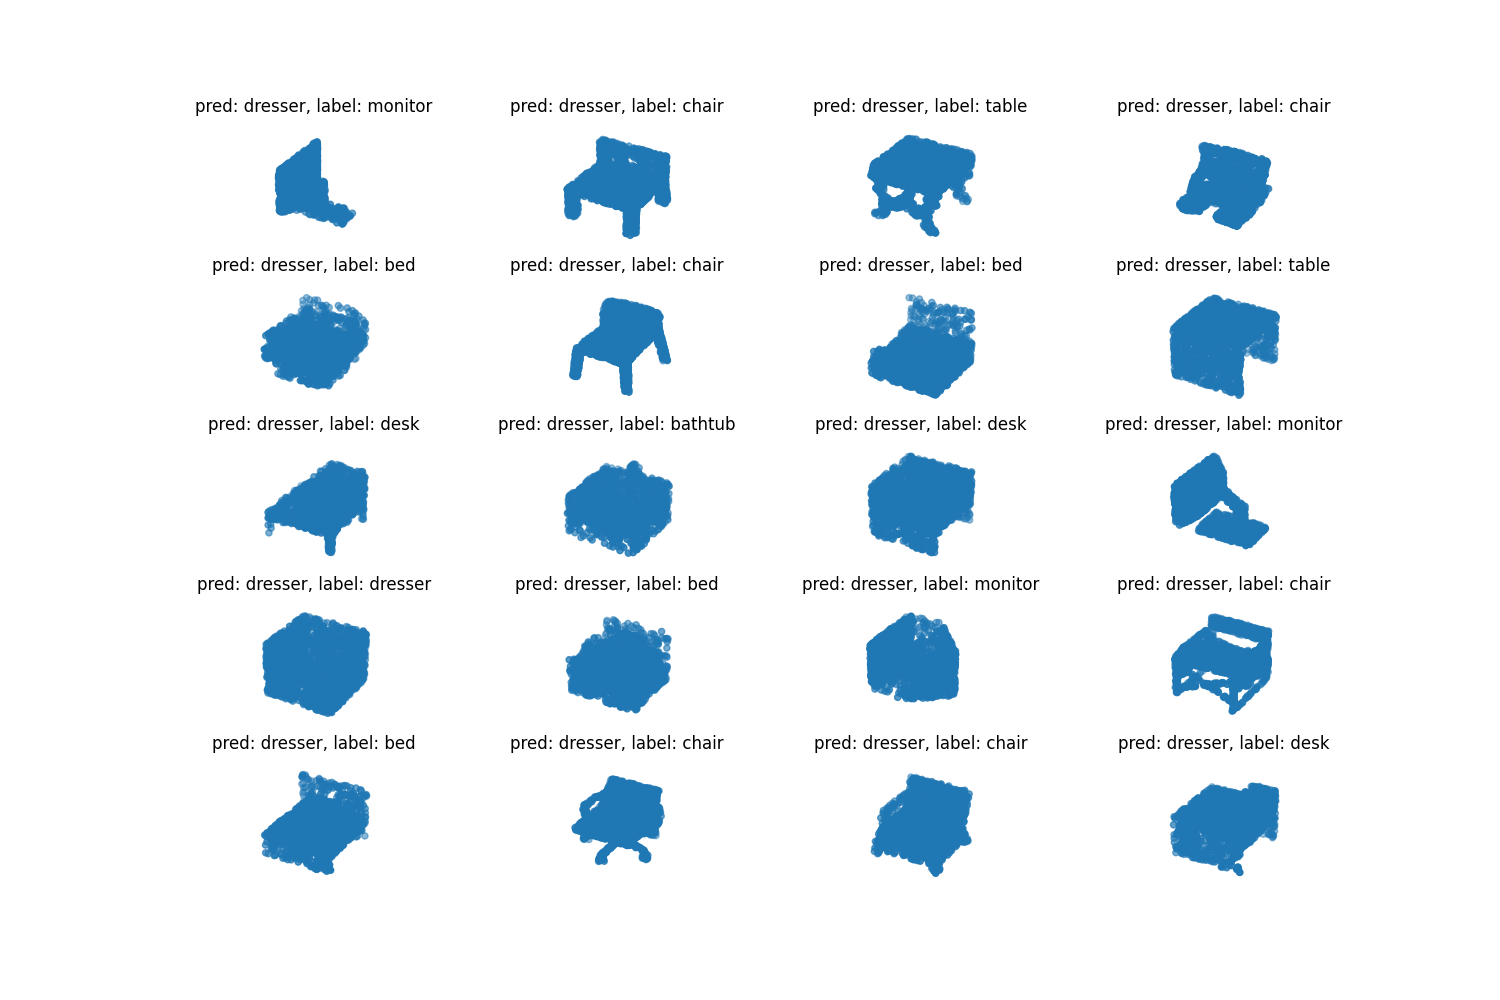

Reusing TensorBoard on port 6006 (pid 340982), started 0:03:03 ago. (Use '!kill 340982' to kill it.)

In [10]:
#%matplotlib widget
# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(evaluate_count):
    ax = fig.add_subplot(5, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            class_map[preds[i].numpy()], class_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

%reload_ext tensorboard
%tensorboard --host 10.180.89.159 --logdir logs